In [1]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-deep')
from matplotlib_venn import venn2, venn3

# cm = mpl.colors.ListedColormap(['red', 'darkgreen', 'blue'])

from lifelines.utils import concordance_index

from scipy.stats import ranksums, kruskal, pearsonr, spearmanr


In [2]:
"""
    Data loading
"""

# Directory containing all data used in this notebook
data_dir = "/home/colin/Documents/BHKLab/data/DA_detection_paper/"

# GTV locations
# Nearest pixel to DA
df_gtv = pd.read_csv(os.path.join(data_dir, "radcure_gtv_nearest.csv"), index_col="patient_id")
# GTV Centre of mass
df_gtv_com = pd.read_csv(os.path.join(data_dir, "radcure_gtv_coms.csv"), index_col="patient_id")

# Dental artifact labels (DAL)
df_dal = pd.read_csv(os.path.join(data_dir, "radcure_DA_labels.csv"),
                    index_col="patient_id", usecols=["patient_id", "has_artifact", "a_slice"])

# Radiomic Features
rad_file = os.path.join(data_dir, "pyradiomic_features.csv")
df_rad = pd.read_csv(rad_file, index_col="ID")


In [3]:
"""
Data Cleaning
"""

# Rename some poorly named columns
df_dal = df_dal.rename(columns={"has_artifact": "DA_mag", "a_slice": "DA_loc"},
                       index={"patient_id": "ID"})
df_gtv = df_gtv.rename(columns={"distance": "delta"})

# Make column of distance from GTV nearest pixel to DA slice
df_gtv["delta_z"] = (df_gtv["GTVz"] - df_gtv["DAz"]).abs()

# Make column if distance from GTV CoM to DA slice
# df_gtv["delta_z_com"] = (df_gtv_com["GTVz"] - df_gtv["DAz"]).abs()

# Combine the GTV locations and DA locations into one CSV
loc_data = df_gtv
loc_data["DA_mag"] = df_dal["DA_mag"]

# Combine all features with location data
data_withna = pd.concat([df_rad, loc_data], axis=1)
feat_cols = df_rad.columns

# Drop rows containing NaNs
data = data_withna.dropna()


In [4]:
data

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,...,wavelet-LLL_ngtdm_Strength,delta,GTVz,GTVy,GTVx,DAz,DAy,DAx,delta_z,DA_mag
94330,0.439307,-0.274048,0.476748,0.757679,0.873359,0.598967,0.570992,0.629290,0.182359,1.107154,...,-0.124330,0.0,184.0,0.0,0.0,184.0,188.0,206.0,0.0,0
104191,0.476244,0.039386,-0.956633,-1.095067,-1.123800,-0.991693,-0.846709,-1.063426,-0.717445,-0.927426,...,-0.006985,-70.0,178.0,0.0,0.0,248.0,145.0,255.0,70.0,2
106580,-1.050071,-0.673093,-0.009778,0.515752,0.627378,0.693637,-0.241354,0.467406,-0.057661,-0.088355,...,-0.353241,0.0,210.0,0.0,0.0,210.0,134.0,231.0,0.0,1
126935,-1.373617,-1.168283,-1.186582,-0.839775,-1.439833,-0.627754,-0.395958,-0.839052,-0.719962,-1.257216,...,-0.301557,-84.0,170.0,0.0,0.0,254.0,104.0,255.0,84.0,2
136555,-0.227295,-0.843523,0.957752,2.103302,1.481937,1.910221,1.827041,2.052497,2.356550,1.948938,...,0.224537,0.0,244.0,0.0,0.0,244.0,133.0,274.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364999,-0.457640,-0.310526,1.195361,1.670291,1.101807,1.579741,1.128054,1.814155,1.116858,1.332326,...,-0.208598,-4.0,214.0,0.0,0.0,218.0,129.0,221.0,4.0,1
6367171,-1.948693,-0.731284,-1.050127,-0.882295,-1.504709,-0.881642,-0.673090,-1.047456,-0.716108,-1.473036,...,0.013290,-48.0,156.0,0.0,0.0,204.0,124.0,267.0,48.0,0
6376916,0.030771,0.277523,0.208118,0.034308,0.120208,-0.033255,-0.152702,-0.114568,-0.291705,0.096440,...,-0.227277,0.0,218.0,0.0,0.0,218.0,120.0,267.0,0.0,1
6378589,-1.147845,-0.448164,-0.159284,0.119407,-0.084955,0.146886,-0.391159,0.202144,-0.366556,-0.451356,...,-0.107232,-6.0,214.0,0.0,0.0,220.0,144.0,268.0,6.0,1


In [5]:
""" 
    Print Number of samples from each DA class
"""

# Get DF for each DA type
s_df = data[data["DA_mag"] == 2]
w_df = data[data["DA_mag"] == 1]
n_df = data[data["DA_mag"] == 0]

print(len(s_df))
print(len(w_df))
print(len(n_df))


983
715
838


In [6]:
""" Compute Wilcoxon Rank-Sum between features from Strong DA and features from no DA, for 
    different DA-GTV distance bins
"""
# Define distance bins
distance_bins = [0,40, 80, 120, 160]

# Define columns to drop to create DF of features only and DA mag
drop_cols = ["DAz", "DAx", "DAy", "GTVz", "GTVy", "GTVx", "delta",
             "delta_z", 
#              "delta_z_com", 
             "DA_mag"]

features = data.drop(columns=drop_cols).columns
n_tests = len(features)

# Name of distance measure (delta_z or delta_z_com)
distance_name = "delta_z"


# Create an empty dataframe for the results
wilcox_df = pd.DataFrame(index=features)

# For each distance bin, compute statistic
for i in range(len(distance_bins) - 1) :
    min_, max_ = distance_bins[i], distance_bins[i + 1]
    
    # Get data from this distance range
    s_data = s_df[(min_ <= s_df[distance_name].abs()) & (s_df[distance_name].abs() < max_)]
    n_data = n_df[(min_ <= n_df[distance_name].abs()) & (n_df[distance_name].abs() < max_)]
    
    p = [] # A list of one p-value for each feature
    for f in features :
        # For each feature, compute statistic and save p-value
        p.append(ranksums(s_data[f], n_data[f])[1])
        
    # Add result from this distance range to df
    col_name = str(min_)+"-"+str(max_)+"mm"
    wilcox_df[col_name] = p
    
# Apply Bonferronni correction
wilcox_df = wilcox_df * n_tests

/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/scipy/stats/stats.py:6475: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [7]:
""" Print number of features with p < 0.05 """
(wilcox_df.iloc[:, 0:] < 0.05).sum()

0-40mm       442
40-80mm       55
80-120mm       0
120-160mm      0
dtype: int64

In [8]:
def append_sig(value, val_list, p, sig_p=0.05) :
    """ Append a value to a list (val_list) if its p-value is significant 
    (p < sig_p). Otherwise, append zero."""
    if p < sig_p :
        val_list.append(value)
    else :
        val_list.append(0.0)

In [9]:
""" Compute Pearson, Spearman, and partial Spearman correlation of 
   features with DA-GTV distance
"""
# Empty lists of concordance indeces for each feature
s_CI, w_CI, n_CI = [], [], [] # Concordance index
s_sp, w_sp, n_sp = [], [], [] # Spearman correlation
s_pe, w_pe, n_pe = [], [], [] # Pearson correlation
s_pc, w_pc, n_pc = [], [], [] # Spearman patial correlation controlling for volume

vol_name = 'original_shape_MeshVolume'  # Change this to try different volume metric
distance_name = "delta_z"  # Change this to try GTV CoM or GTV nearest pixel


import pingouin as pg  # Needed for patial correlation

for feature in features :
    
    # Compute Pearson correlation for each DA type
    s_pe.append(pearsonr(s_df[distance_name].values, s_df[feature].values)[0])
    w_pe.append(pearsonr(w_df[distance_name].values, w_df[feature].values)[0])
    n_pe.append(pearsonr(n_df[distance_name].values, n_df[feature].values)[0])
    
    # Compute Spearman correlation and p-value for each DA type
    s_r, s_p = spearmanr(s_df[distance_name].values, s_df[feature].values)
    w_r, w_p = spearmanr(w_df[distance_name].values, w_df[feature].values)
    n_r, n_p = spearmanr(n_df[distance_name].values, n_df[feature].values)
    
    # If p-value is not significant (< 0.05), reject the R value by setting to zero
    append_sig(s_r, s_sp, s_p * n_tests)
    append_sig(w_r, w_sp, w_p * n_tests)
    append_sig(n_r, n_sp, n_p * n_tests)
        
    if feature == vol_name :
        # Fill vol, vol correlation with NaNs
        s_pc.append(np.nan)
        w_pc.append(np.nan)
        n_pc.append(np.nan)
    else :
        
        # Compute partial correlation for each feature with GTV-DA distance, 
        # controlling for volume
        strong = s_df.partial_corr(x=distance_name, y=feature,
                                   covar=[vol_name], method='spearman')
        weak   = w_df.partial_corr(x=distance_name, y=feature,
                                   covar=[vol_name], method='spearman')
        none   = n_df.partial_corr(x=distance_name, y=feature,
                                   covar=[vol_name], method='spearman')
        
        
        append_sig(strong.at["spearman", "r"], s_pc, strong.at["spearman", "p-val"] * n_tests)
        append_sig(  weak.at["spearman", "r"], w_pc,   weak.at["spearman", "p-val"] * n_tests)
        append_sig(  none.at["spearman", "r"], n_pc,   none.at["spearman", "p-val"] * n_tests)

    
# Make results into a DF
results = pd.DataFrame(data={"s_sp": s_sp, "w_sp": w_sp, "n_sp": n_sp,  # Spearman 
                             "s_pe": s_pe, "w_pe": w_pe, "n_pe": n_pe,  # Pearson
                             "s_pc": s_pc, "w_pc": w_pc, "n_pc": n_pc, # Spearman partial corr
                             },
                            index=features)

/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [10]:
results

,s_sp,w_sp,n_sp,s_pe,w_pe,n_pe,s_pc,w_pc,n_pc
original_shape_Elongation,0.000000,0.000000,0.000000,-0.047670,-0.086272,-0.036613,0.000000,0.000000,0.000000
original_shape_Flatness,-0.217050,-0.271801,-0.183208,-0.265344,-0.304077,-0.199397,0.000000,-0.177516,0.000000
original_shape_LeastAxisLength,-0.520714,-0.566943,-0.571919,-0.528770,-0.539967,-0.544246,-0.280273,-0.347418,-0.320493
original_shape_MajorAxisLength,-0.527920,-0.539656,-0.607597,-0.461015,-0.424957,-0.509086,-0.344449,-0.347174,-0.423310
original_shape_Maximum2DDiameterColumn,-0.558746,-0.581247,-0.636325,-0.551452,-0.556190,-0.579225,-0.399462,-0.435956,-0.475591
...,...,...,...,...,...,...,...,...,...
wavelet-LLL_ngtdm_Busyness,-0.281355,-0.390603,-0.471619,-0.208384,-0.182381,-0.189786,-0.142012,-0.183886,-0.202225
wavelet-LLL_ngtdm_Coarseness,0.516133,0.574067,0.623150,0.515943,0.552906,0.403649,0.429072,0.527054,0.516414
wavelet-LLL_ngtdm_Complexity,-0.210087,-0.196941,-0.166593,-0.138757,-0.137847,-0.210211,0.000000,0.000000,0.000000
wavelet-LLL_ngtdm_Contrast,0.376151,0.456261,0.515776,0.346472,0.277180,0.297464,0.371815,0.419118,0.417093


## Plotting Venn Diagrams
Plot the features above a given correlation value, grouped by DA type.

In [11]:
def embed_venn(corr, title="", nameA="A", nameB="B", nameC="C", plot=True) :
    colA, colB, colC = corr.columns.values
#     print(colA, colB, colC)
    A = sum((corr[colA]==True) & (corr[colB]==False) & (corr[colC]==False)) # A
    B = sum((corr[colA]==False) & (corr[colB]==True) & (corr[colC]==False)) # B
    C = sum((corr[colA]==False) & (corr[colB]==False) & (corr[colC]==True)) # C
    
    AB = sum( (corr[colA]==True) & (corr[colB]==True) & (corr[colC]==False) )
    AC = sum( (corr[colA]==True) & (corr[colB]==False) & (corr[colC]==True) )
    BC = sum( (corr[colA]==False) & (corr[colB]==True) & (corr[colC]==True) )
    
    ABC = sum( (corr[colA]==True) & (corr[colB]==True) & (corr[colC]==True))
    
    if plot :
#         plt.figure()
        plt.title(title)
        venn3(subsets=[A, B, AB, C, AC, BC, ABC], 
               set_labels=(nameA, nameB, nameC)
             )
        plt.show()
        return
    else :
        return [A, B, C, AB, AC, BC, ABC]

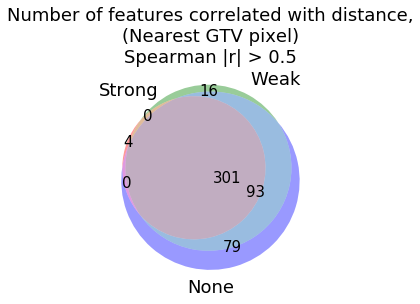

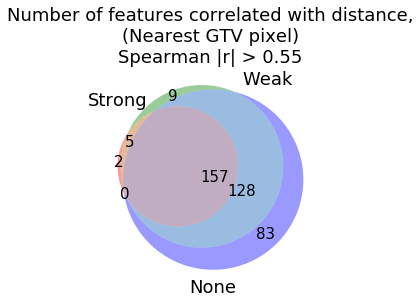

/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


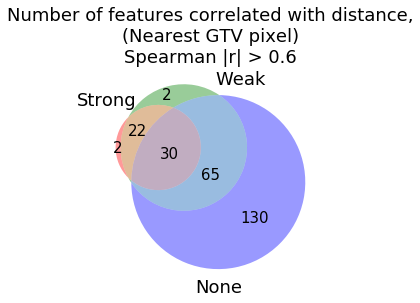

                                                   s_sp   w_sp   n_sp
lbp-3D-k_firstorder_90Percentile                   True  False  False
lbp-3D-k_firstorder_Entropy                        True  False  False
lbp-3D-k_firstorder_InterquartileRange             True   True   True
lbp-3D-k_firstorder_Kurtosis                       True   True   True
lbp-3D-k_firstorder_MeanAbsoluteDeviation          True  False  False
lbp-3D-k_firstorder_RobustMeanAbsoluteDeviation    True   True   True
lbp-3D-k_firstorder_Skewness                       True   True   True
lbp-3D-k_firstorder_Uniformity                     True  False  False
lbp-3D-k_glcm_Autocorrelation                      True  False  False
lbp-3D-k_glcm_ClusterTendency                      True  False  False
lbp-3D-k_glcm_JointAverage                         True  False  False
lbp-3D-k_glcm_JointEnergy                          True  False  False
lbp-3D-k_glcm_JointEntropy                         True  False  False
lbp-3D-k_glcm_Maximu

/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


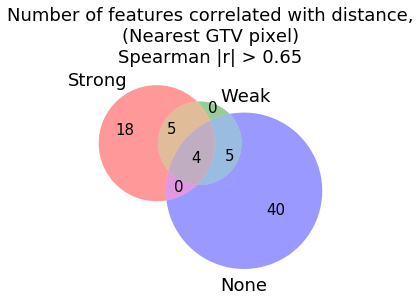

/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:57: UserWarning: Circle B has zero area
  warnings.warn("Circle B has zero area")
/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


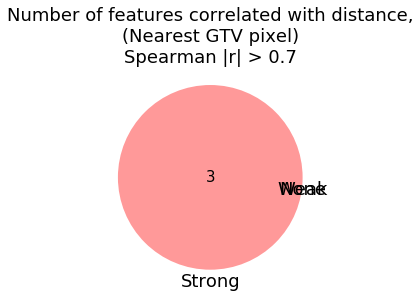

/home/colin/anaconda3/envs/radcure/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:47: UserWarning: All circles have zero area
  warnings.warn("All circles have zero area")


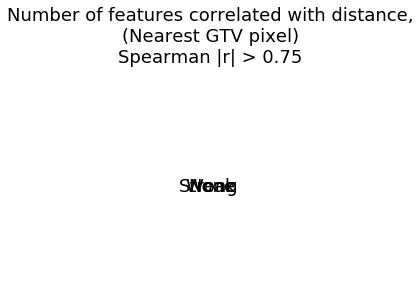

In [12]:
""" Features Spearman-correlated with distance (all features)"""

sp_thresholds = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75]
for t in sp_thresholds :
    corr_df = (results.loc[:, "s_sp" : "n_sp"].abs() > t)
    
    if t == 0.65:
        print(corr_df[corr_df["s_sp"]])
        print(corr_df[corr_df["n_sp"]])
    
    plt.rc('font', family='sans-serif', size=15)
    fig = plt.figure()
    fig.set_facecolor('white')
    
    # Make two Venn Diagrams
    # Concorance index with feature and distance
    embed_venn(corr_df.loc[:,"s_sp":"n_sp"], 
           title=
                 "Number of features correlated with distance,\n(Nearest GTV pixel)\n"+
                 "Spearman |r| > "+str(t), 
           nameA="Strong", nameB="Weak", nameC="None")


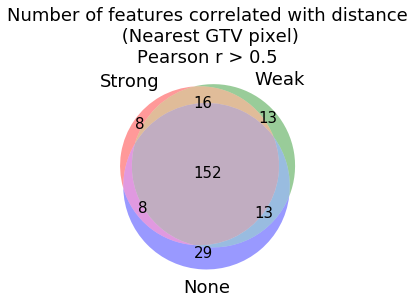

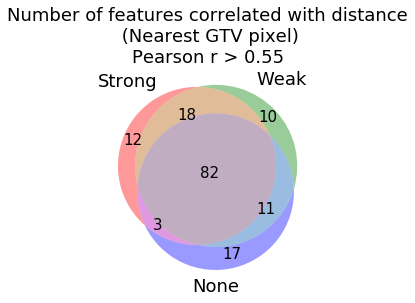

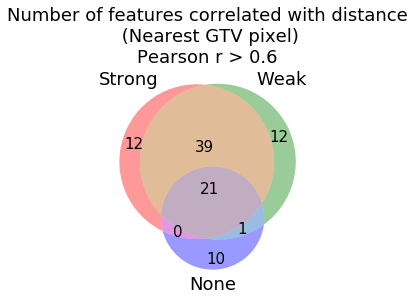

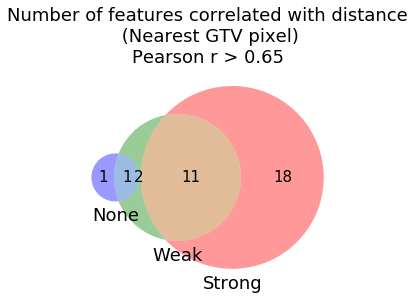

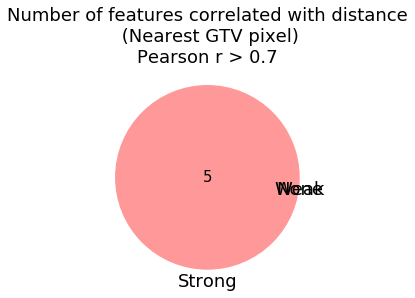

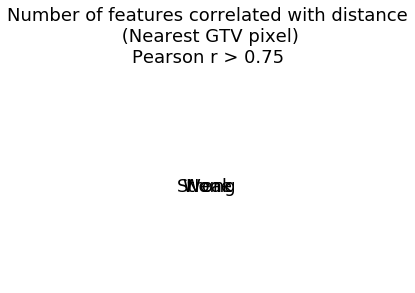

In [13]:
"""  Features Pearson-correlated with distance"""

sp_thresholds = [0.5, 0.55, 0.60, 0.65, 0.70, 0.75]
for t in sp_thresholds :
    corr_df = (results.loc[:, "s_pe" : "n_pe"].abs() > t)
    
    plt.rc('font', family='sans-serif', size=15)
    fig = plt.figure()
    fig.set_facecolor('white')
    
    # Make two Venn Diagrams
    # Concorance index with feature and distance
    embed_venn(corr_df.loc[:,"s_pe":"n_pe"], 
           title=
                 "Number of features correlated with distance\n (Nearest GTV pixel)\n"+
                 "Pearson r > "+str(t), 
           nameA="Strong", nameB="Weak", nameC="None")

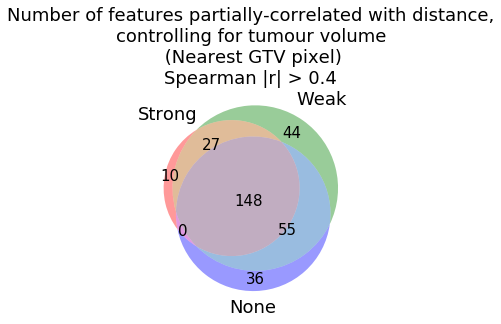

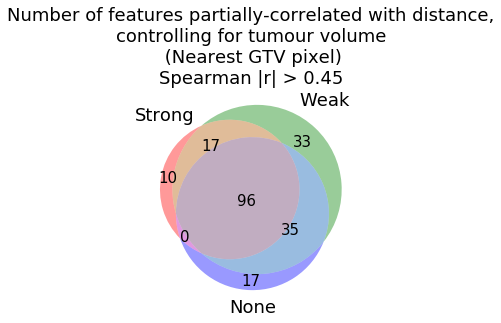

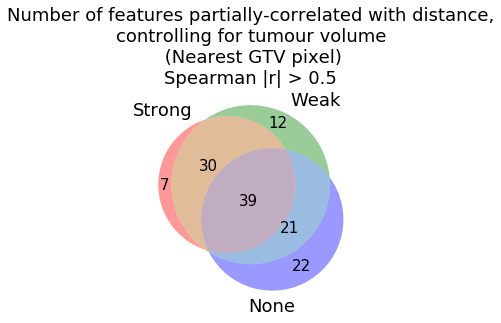

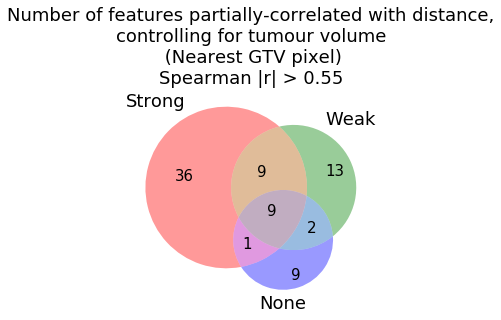

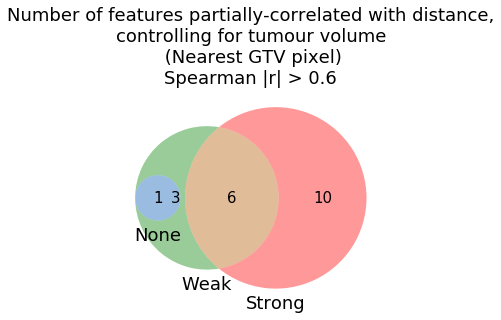

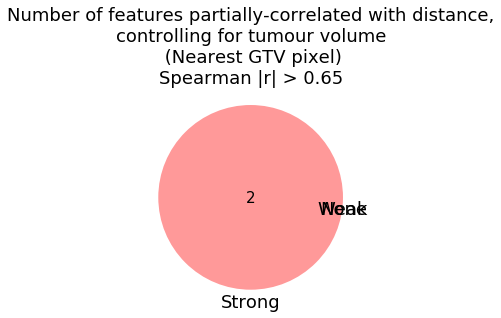

In [14]:
""" Features Partially (Spearman)-correlated with distance controlling for volume"""

sp_thresholds = [0.4, 0.45, 0.50, 0.55, 0.60, 0.65]
for t in sp_thresholds :
    # Features with correlation or anti-correlation larger than t
    corr_df = (results.loc[:, "s_pc" : "n_pc"].abs() > t)
    
    # Uncomment this to print the names of the features above this r cutoff
    # if t == 0.55:
    #     print(corr_df[corr_df["s_pc"]])
    #     print(corr_df[corr_df["n_pc"]])
    
    plt.rc('font', family='sans-serif', size=15)
    fig = plt.figure()
    fig.set_facecolor('white')
    
    # Make two Venn Diagrams
    # Concorance index with feature and distance
    embed_venn(corr_df.loc[:,"s_pc":"n_pc"], 
           title=
                 "Number of features partially-correlated with distance,\n"+
                 "controlling for tumour volume\n (Nearest GTV pixel)\n"+
                 "Spearman |r| > "+str(t), 
           nameA="Strong", nameB="Weak", nameC="None")

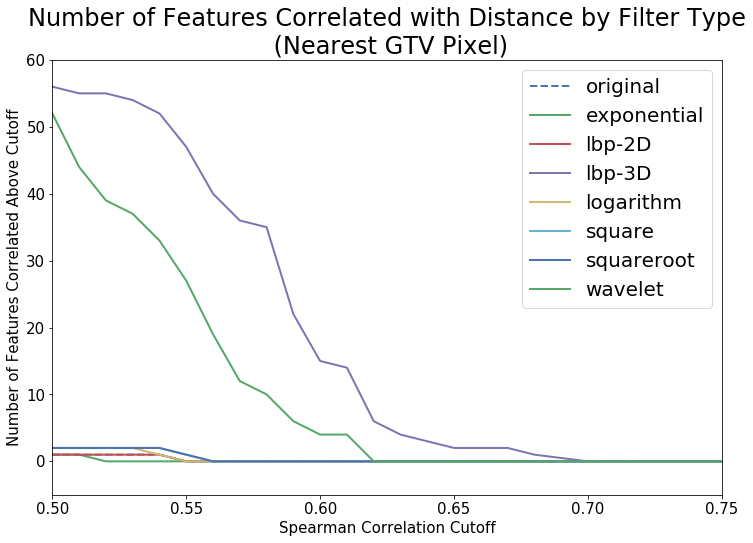

In [15]:
# Make a graph of number of features per filter type
sp_thresholds = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
                 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.7, 
                 0.71, 0.72, 0.73, 0.74, 0.75]#, 0.76, 0.77, 0.78, 0.79, 0.8]

filter_types = ["original","exponential","lbp-2D","lbp-3D",
                 "logarithm","square","squareroot","wavelet"]



fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
plt.rc('font', family='sans-serif', size=20)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for f in filter_types :
    num_feats = []
    
    # Get name of features which include this group
    feats = results.index[results.index.str.contains(f)]
    group_data = results.loc[feats, "s_pc" : "n_pc" ] # Data from only these features
    
    
    for t in sp_thresholds :
        corrs_df = group_data.abs() > t
        n = corrs_df[corrs_df["s_pc"] |  corrs_df["w_pc"] | corrs_df["n_pc"]]
        num_feats.append(len(n))
    
    if f == "original" :
        ax.plot(sp_thresholds, num_feats, linestyle='dashed', linewidth=2, label=f)
    else :
        ax.plot(sp_thresholds, num_feats, label=f, linewidth=2,)


ax.set_title("Number of Features Correlated with Distance by Filter Type\n (Nearest GTV Pixel)")
ax.set_xlabel("Spearman Correlation Cutoff")
ax.set_ylabel("Number of Features Correlated Above Cutoff")
ax.set_ylim([-5, 60])
ax.set_xlim([0.50, 0.75])
plt.legend()
plt.show()
    
    
    

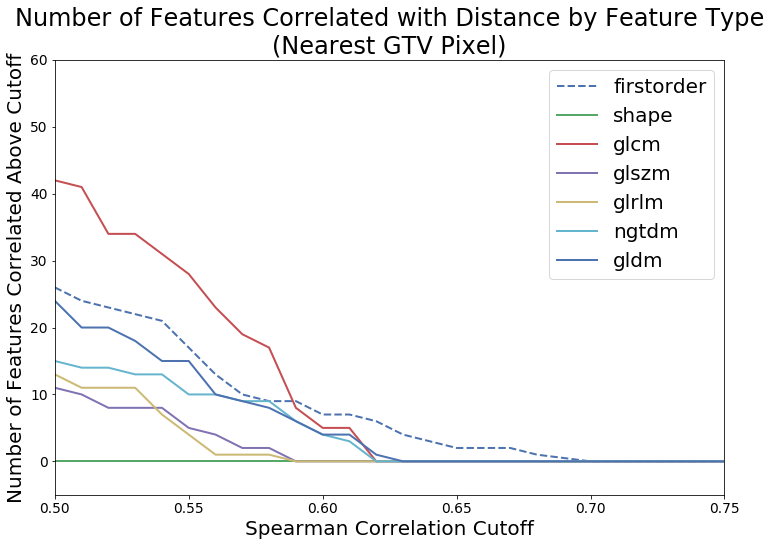

In [16]:
feat_types = ["firstorder","shape","glcm", "glszm","glrlm","ngtdm","gldm"]
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor('white')
# mpl.style.use("classic")
plt.rc('font', family='sans-serif', size=20)
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

for f in feat_types :
    num_feats = []
    
    # Get name of features which include this group
    feats = results.index[results.index.str.contains(f)]
    group_data = results.loc[feats, "s_pc" : "n_pc" ] # Data from only these features
    
    for t in sp_thresholds :
        corrs_df = group_data.abs() > t
        n = corrs_df[corrs_df["s_pc"] |  corrs_df["w_pc"] | corrs_df["n_pc"]]
        num_feats.append(len(n))
    
    if f == "firstorder" :
        ax.plot(sp_thresholds, num_feats, linestyle='dashed', linewidth=2, label=f)
    else :
        ax.plot(sp_thresholds, num_feats, label=f, linewidth=2)


ax.set_title("Number of Features Correlated with Distance by Feature Type\n(Nearest GTV Pixel)")
ax.set_xlabel("Spearman Correlation Cutoff")
ax.set_ylabel("Number of Features Correlated Above Cutoff")
ax.set_ylim([-5, 60])
ax.set_xlim([0.50, 0.75])
plt.legend()
plt.show()